In [2]:
import os
os.chdir(r'C:\Users\DELL\Personal Project\Supervised_Learning\Classifier')

In [3]:
from DecisionTree import DecisionTree

Custom DecisionTree accuracy: 0.9629629629629629
Sklearn DecisionTree accuracy: 0.9444444444444444


In [4]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.datasets import fetch_covtype
from sklearn.model_selection import train_test_split, StratifiedKFold, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, hinge_loss, make_scorer
from sklearn.pipeline import Pipeline

# Import dataset

In [5]:
data = fetch_covtype()
print(data.DESCR)

.. _covtype_dataset:

Forest covertypes
-----------------

The samples in this dataset correspond to 30×30m patches of forest in the US,
collected for the task of predicting each patch's cover type,
i.e. the dominant species of tree.
There are seven covertypes, making this a multiclass classification problem.
Each sample has 54 features, described on the
`dataset's homepage <https://archive.ics.uci.edu/ml/datasets/Covertype>`__.
Some of the features are boolean indicators,
while others are discrete or continuous measurements.

**Data Set Characteristics:**

=================   ============
Classes                        7
Samples total             581012
Dimensionality                54
Features                     int
=================   ============

:func:`sklearn.datasets.fetch_covtype` will load the covertype dataset;
it returns a dictionary-like 'Bunch' object
with the feature matrix in the ``data`` member
and the target values in ``target``. If optional argument 'as_frame' is
se

In [6]:
df = pd.DataFrame(data.data, columns=data.feature_names)
df[data.target_names[0]] = data.target
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 581012 entries, 0 to 581011
Data columns (total 55 columns):
 #   Column                              Non-Null Count   Dtype  
---  ------                              --------------   -----  
 0   Elevation                           581012 non-null  float64
 1   Aspect                              581012 non-null  float64
 2   Slope                               581012 non-null  float64
 3   Horizontal_Distance_To_Hydrology    581012 non-null  float64
 4   Vertical_Distance_To_Hydrology      581012 non-null  float64
 5   Horizontal_Distance_To_Roadways     581012 non-null  float64
 6   Hillshade_9am                       581012 non-null  float64
 7   Hillshade_Noon                      581012 non-null  float64
 8   Hillshade_3pm                       581012 non-null  float64
 9   Horizontal_Distance_To_Fire_Points  581012 non-null  float64
 10  Wilderness_Area_0                   581012 non-null  float64
 11  Wilderness_Area_1         

,Elevation,Aspect,Slope,Horizontal_Distance_To_Hydrology,Vertical_Distance_To_Hydrology,Horizontal_Distance_To_Roadways,Hillshade_9am,Hillshade_Noon,Hillshade_3pm,Horizontal_Distance_To_Fire_Points,Wilderness_Area_0,Wilderness_Area_1,Wilderness_Area_2,Wilderness_Area_3,Soil_Type_0,Soil_Type_1,Soil_Type_2,Soil_Type_3,Soil_Type_4,Soil_Type_5,Soil_Type_6,Soil_Type_7,Soil_Type_8,Soil_Type_9,Soil_Type_10,Soil_Type_11,Soil_Type_12,Soil_Type_13,Soil_Type_14,Soil_Type_15,Soil_Type_16,Soil_Type_17,Soil_Type_18,Soil_Type_19,Soil_Type_20,Soil_Type_21,Soil_Type_22,Soil_Type_23,Soil_Type_24,Soil_Type_25,Soil_Type_26,Soil_Type_27,Soil_Type_28,Soil_Type_29,Soil_Type_30,Soil_Type_31,Soil_Type_32,Soil_Type_33,Soil_Type_34,Soil_Type_35,Soil_Type_36,Soil_Type_37,Soil_Type_38,Soil_Type_39,Cover_Type
0,2596.0,51.0,3.0,258.0,0.0,510.0,221.0,232.0,148.0,6279.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
1,2590.0,56.0,2.0,212.0,-6.0,390.0,220.0,235.0,151.0,6225.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5
2,2804.0,139.0,9.0,268.0,65.0,3180.0,234.0,238.0,135.0,6121.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
3,2785.0,155.0,18.0,242.0,118.0,3090.0,238.0,238.0,122.0,6211.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2
4,2595.0,45.0,2.0,153.0,-1.0,391.0,220.0,234.0,150.0,6172.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,5


# EDA

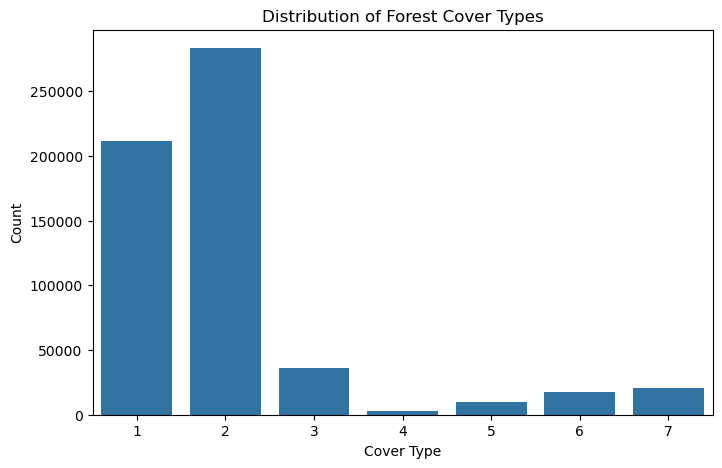

Cover_Type
2    283301
1    211840
3     35754
7     20510
6     17367
5      9493
4      2747
Name: count, dtype: int64


In [7]:
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=df["Cover_Type"])
plt.title("Distribution of Forest Cover Types")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.show()

# Print class counts
print(df["Cover_Type"].value_counts())

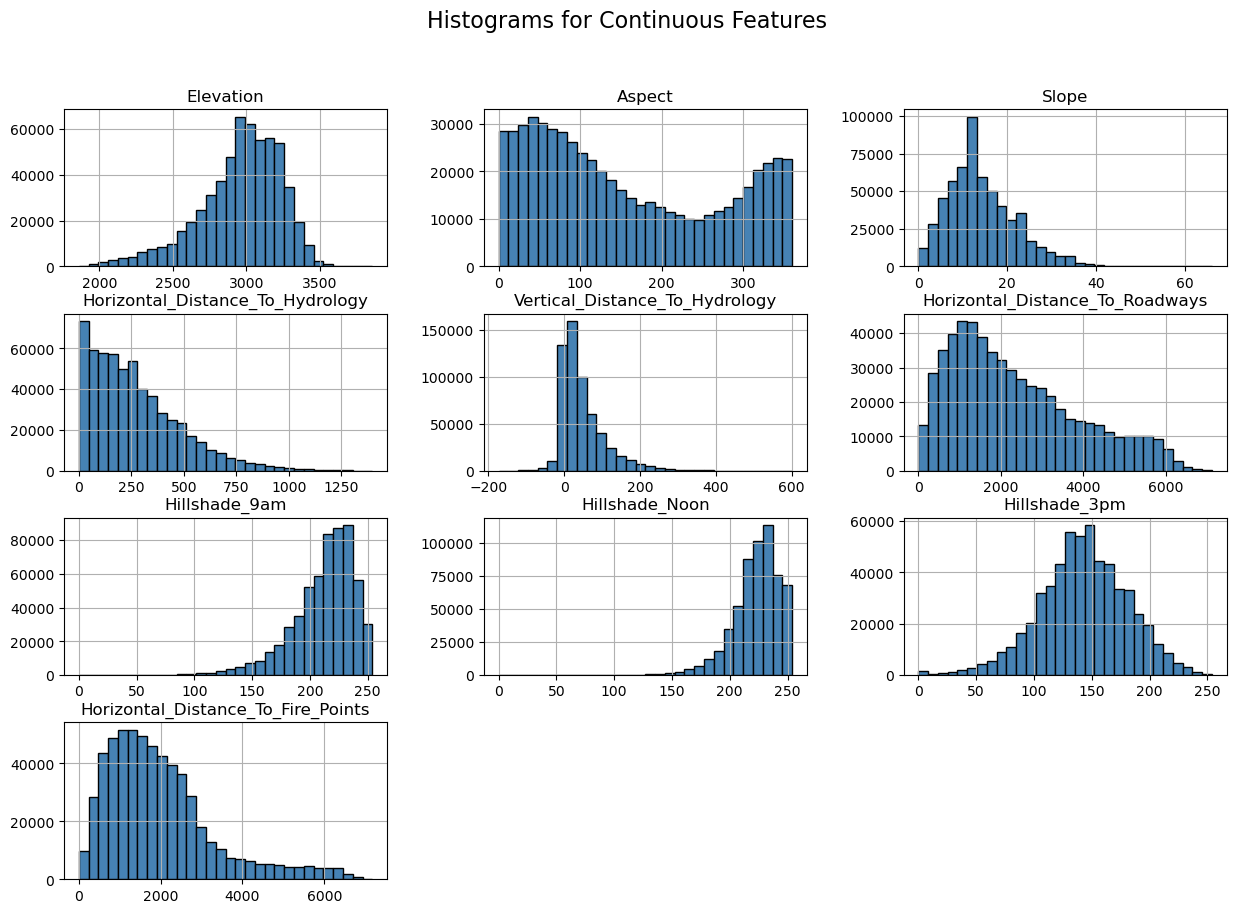

Skewness of Continuous Features:
Elevation                            -0.817596
Aspect                                0.402628
Slope                                 0.789273
Horizontal_Distance_To_Hydrology      1.140437
Vertical_Distance_To_Hydrology        1.790250
Horizontal_Distance_To_Roadways       0.713679
Hillshade_9am                        -1.181147
Hillshade_Noon                       -1.063056
Hillshade_3pm                        -0.277053
Horizontal_Distance_To_Fire_Points    1.288644
dtype: float64


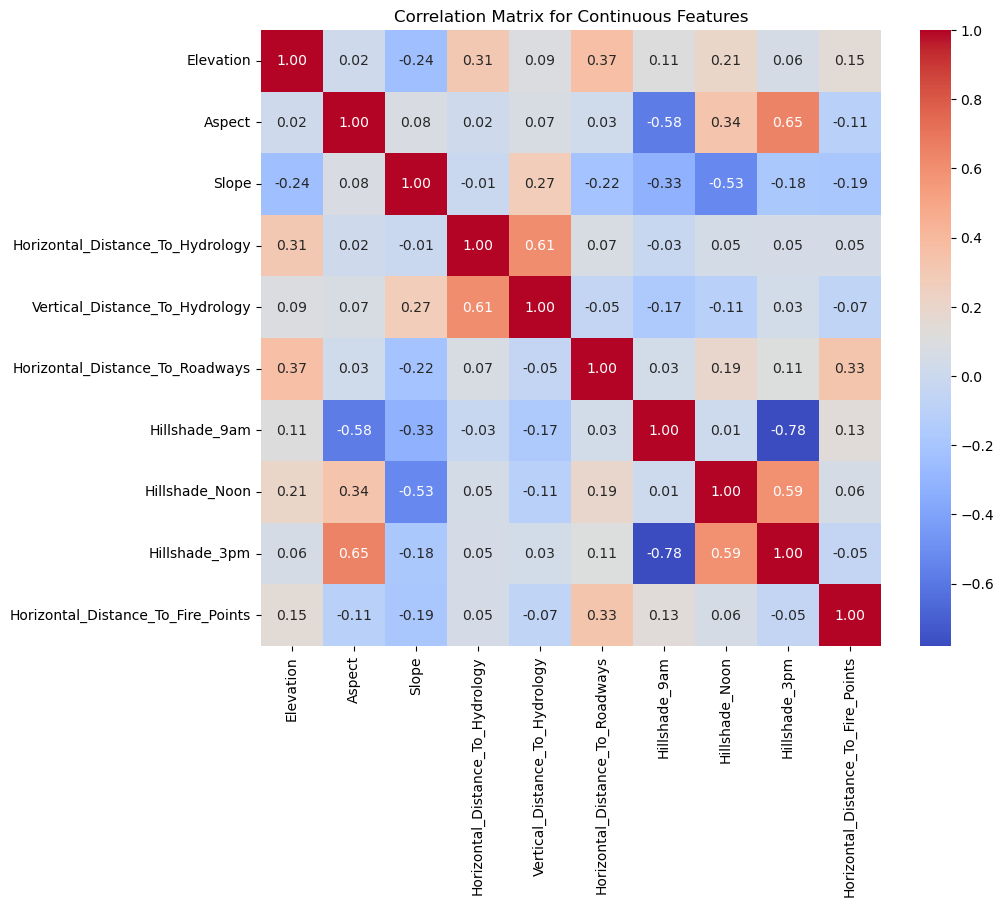

In [8]:
continuous_cols = df.columns[:10]
# Histograms for continuous features
df[continuous_cols].hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle("Histograms for Continuous Features", fontsize=16)
plt.show()

# Calculate skewness for all continuous features (first 10 columns)
skewness = df.iloc[:, :10].skew()
print("Skewness of Continuous Features:")
print(skewness)

# Correlation matrix for continuous features
corr_matrix = df[continuous_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Continuous Features")
plt.show()

transform skewness on whole dataset
choose subset similar to original dataset, visual to confirm
train sklearn model on both datasets to evaluate
improve performance 
apply all the techniques to self made model on subset 

# Building model

## Split into training and test sets 

> The entire dataset is too large. To save time, only 1% of the dataset is used to train the model, instead of 70 or 80% as usual . However, the training dataset should be representative of the original dataset.

In [9]:
X, y = df.drop(columns = ['Cover_Type']), df['Cover_Type']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.9, stratify=y, random_state=42)
training_set = pd.DataFrame(X_train, columns=data.feature_names)
training_set[data.target_names[0]] = y_train

## Visualize the training set

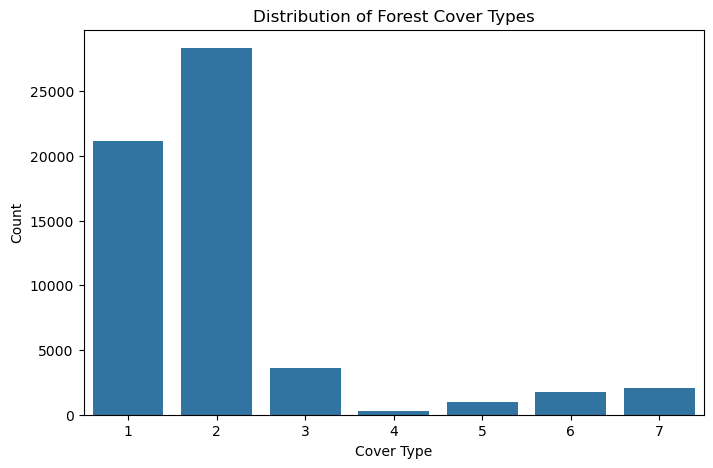

Cover_Type
2    28330
1    21184
3     3575
7     2051
6     1737
5      949
4      275
Name: count, dtype: int64


In [10]:
# Plot class distribution
plt.figure(figsize=(8, 5))
sns.countplot(x=training_set["Cover_Type"])
plt.title("Distribution of Forest Cover Types")
plt.xlabel("Cover Type")
plt.ylabel("Count")
plt.show()

# Print class counts
print(training_set["Cover_Type"].value_counts())

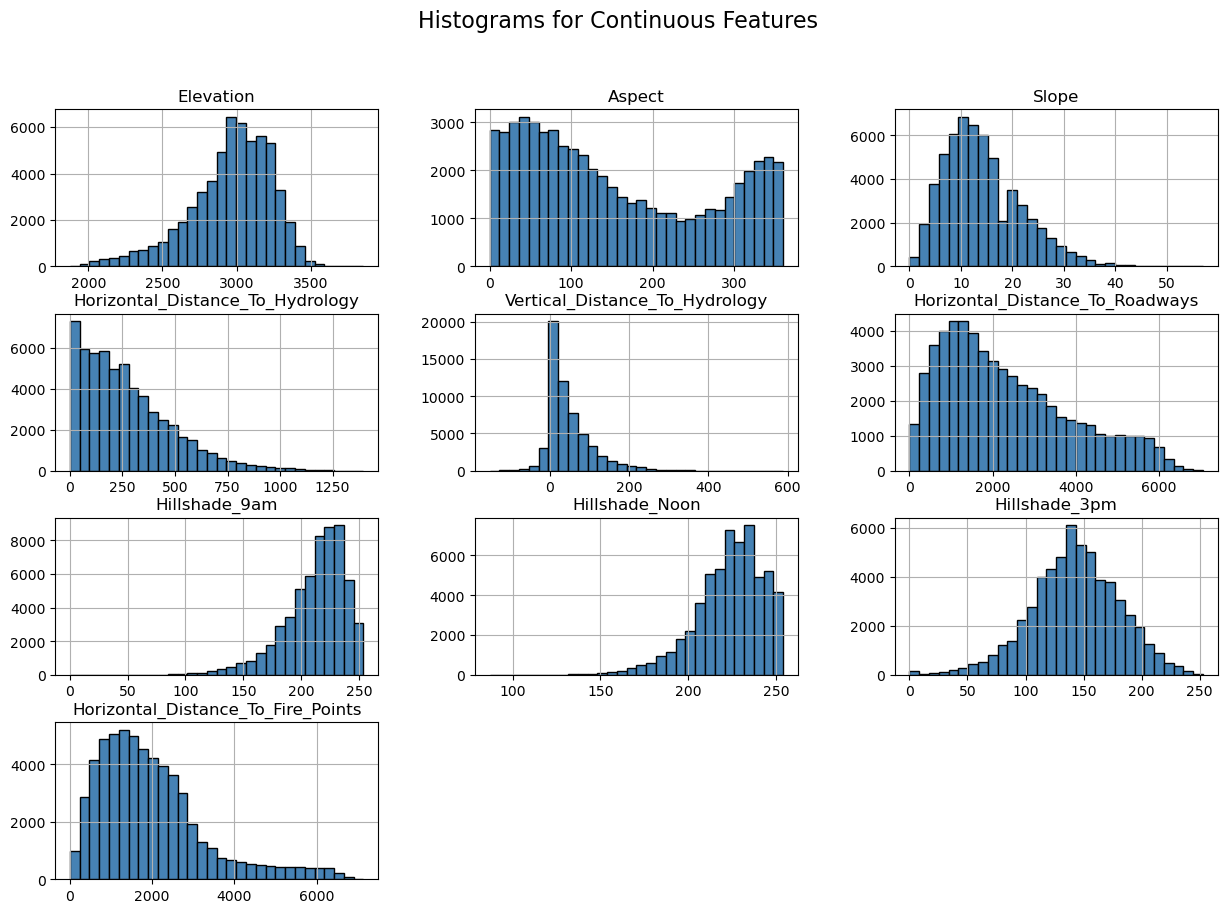

Skewness of Continuous Features:
Elevation                            -0.815522
Aspect                                0.404658
Slope                                 0.793644
Horizontal_Distance_To_Hydrology      1.143785
Vertical_Distance_To_Hydrology        1.841923
Horizontal_Distance_To_Roadways       0.720402
Hillshade_9am                        -1.206592
Hillshade_Noon                       -1.024488
Hillshade_3pm                        -0.271171
Horizontal_Distance_To_Fire_Points    1.287785
dtype: float64


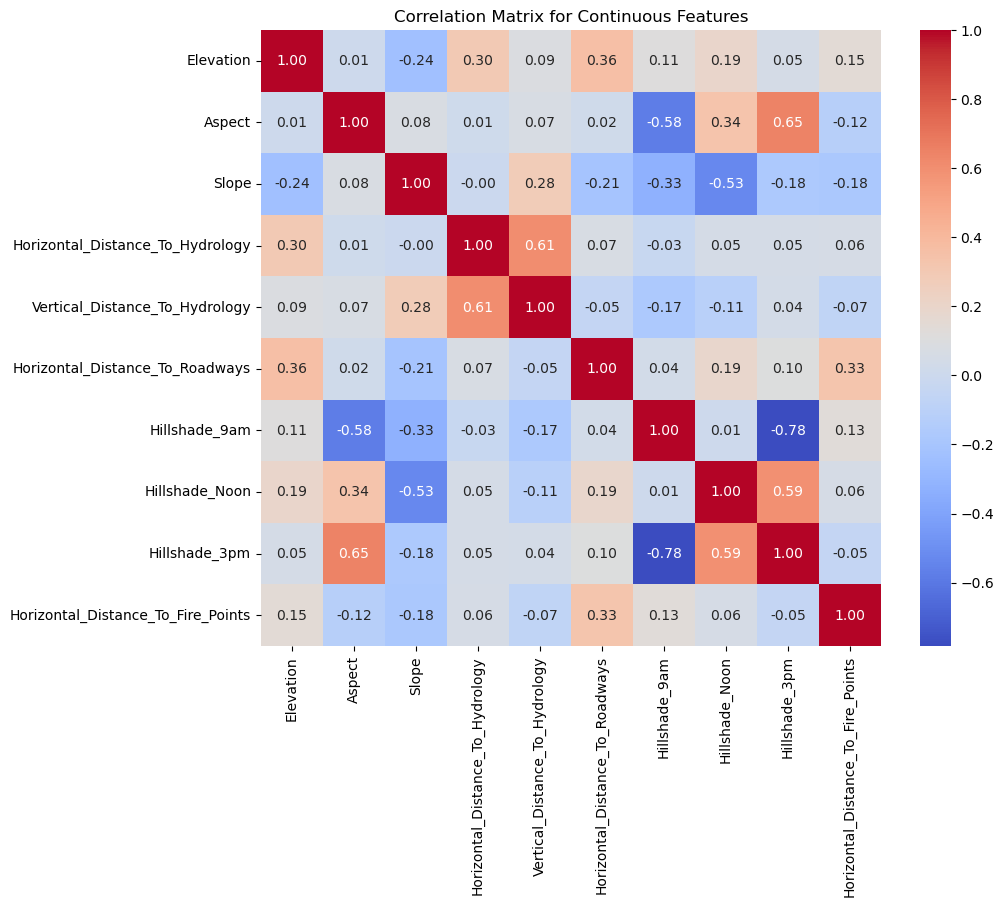

In [11]:
continuous_cols = training_set.columns[:10]
# Histograms for continuous features
training_set[continuous_cols].hist(bins=30, figsize=(15, 10), color='steelblue', edgecolor='black')
plt.suptitle("Histograms for Continuous Features", fontsize=16)
plt.show()

# Calculate skewness for all continuous features (first 10 columns)
skewness = training_set.iloc[:, :10].skew()
print("Skewness of Continuous Features:")
print(skewness)

# Correlation matrix for continuous features
corr_matrix = training_set[continuous_cols].corr()
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title("Correlation Matrix for Continuous Features")
plt.show()

> The visualization shows the similarity between the training data and the original data.

## Function to evaluate the model

In [12]:
def evaluate_multiclass(y_true, y_pred):
    # Print Classification Report (Ensuring all classes are considered)
    print("Classification Report:")
    print(classification_report(y_true, y_pred))

    # Compute Confusion 
    print("Confusion_matrix:")
    print(confusion_matrix(y_true, y_pred))

##  Decision Tree Model

In [16]:
tree = DecisionTree(max_depth=20, ccp_alpha=0)
tree.fit(X_train, y_train)

In [17]:
y_pred = tree.predict(X_test)
evaluate_multiclass(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           1       0.81      0.61      0.69    190656
           2       0.87      0.59      0.70    254971
           3       0.80      0.68      0.73     32179
           4       0.23      0.85      0.37      2472
           5       0.10      0.89      0.18      8544
           6       0.47      0.68      0.55     15630
           7       0.25      0.96      0.40     18459

    accuracy                           0.62    522911
   macro avg       0.50      0.75      0.52    522911
weighted avg       0.79      0.62      0.68    522911

Confusion_matrix:
[[115610  21148     72      0  11439    586  41801]
 [ 26088 151095   2816    111  56454   7730  10677]
 [    39   1020  21821   5047    754   3498      0]
 [     0     13    249   2109      0    101      0]
 [    68    543    155      0   7629    149      0]
 [    61    612   2223   1717    388  10629      0]
 [   606     91      0      0     42      0  17720

## Bagging Model - Random Forest

In [14]:
from sklearn.ensemble import BaggingClassifier

n_features = X_train.shape[1]

In [13]:
base_tree1 = DecisionTree(max_depth=20, max_features=int( np.sqrt(n_features) ) ) 

rf1 = BaggingClassifier(
    estimator=base_tree1,
    n_estimators=10,
    bootstrap=True,
    random_state=42
)

rf1.fit(X_train, y_train)

BaggingClassifier(estimator=<DecisionTree.DecisionTree object at 0x00000191387A3050>,
                  random_state=42)

In [14]:
y_pred = rf1.predict(X_test)
evaluate_multiclass(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           1       0.77      0.71      0.74    190656
           2       0.85      0.62      0.72    254971
           3       0.68      0.61      0.64     32179
           4       0.24      0.90      0.38      2472
           5       0.14      0.85      0.24      8544
           6       0.39      0.75      0.52     15630
           7       0.40      0.93      0.56     18459

    accuracy                           0.67    522911
   macro avg       0.50      0.77      0.54    522911
weighted avg       0.77      0.67      0.70    522911

Confusion_matrix:
[[136290  25340    216      0   8172    691  19947]
 [ 38845 156978   6507    207  35788  10341   6305]
 [     1    228  19607   5380    256   6707      0]
 [     0      0    106   2237      0    129      0]
 [    86    581    328      0   7295    249      5]
 [     8    219   1936   1525    235  11707      0]
 [   705    486     51      0     13      0  17204

In [15]:
base_tree2 = DecisionTree(max_depth=10, max_features=int( np.sqrt(n_features) ) ) 

rf2 = BaggingClassifier(
    estimator=base_tree2,
    n_estimators=20,
    bootstrap=True,
    random_state=42
)

rf2.fit(X_train, y_train)

BaggingClassifier(estimator=<DecisionTree.DecisionTree object at 0x000001F9E2967E30>,
                  n_estimators=20, random_state=42)

In [16]:
y_pred = rf2.predict(X_test)
evaluate_multiclass(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.56      0.62    190656
           2       0.80      0.48      0.60    254971
           3       0.73      0.19      0.30     32179
           4       0.16      0.97      0.27      2472
           5       0.06      0.91      0.12      8544
           6       0.34      0.51      0.40     15630
           7       0.30      0.83      0.44     18459

    accuracy                           0.51    522911
   macro avg       0.44      0.63      0.39    522911
weighted avg       0.71      0.51      0.57    522911

Confusion_matrix:
[[106206  28628      1      0  26083   1215  28523]
 [ 45080 121434   1268    799  71528   8285   6577]
 [     0    178   6062   8967  11108   5863      1]
 [     0      0     16   2402      0     54      0]
 [    16    557      7      0   7759    198      7]
 [   136    131   1001   3045   3389   7925      3]
 [   983    446      0      0   1766      0  15264

## Compare to model of sklearn

In [21]:

sk_rf1 = RandomForestClassifier(
    n_estimators=10,
    criterion="gini",
    max_depth=20,
    class_weight="balanced",  
    random_state=42
)

sk_rf1.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=20, n_estimators=10,
                       random_state=42)

In [22]:
y_pred = sk_rf1.predict(X_test)
evaluate_multiclass(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           1       0.92      0.92      0.92    190656
           2       0.95      0.90      0.92    254971
           3       0.95      0.96      0.96     32179
           4       0.89      1.00      0.94      2472
           5       0.46      0.99      0.63      8544
           6       0.83      0.98      0.90     15630
           7       0.91      0.99      0.95     18459

    accuracy                           0.92    522911
   macro avg       0.85      0.96      0.89    522911
weighted avg       0.93      0.92      0.92    522911

Confusion_matrix:
[[174534  12392     25      0   1941    225   1539]
 [ 14080 229618   1269      7   7841   1980    176]
 [     0     39  30793    234    128    985      0]
 [     0      0      6   2460      0      6      0]
 [     2     57     21      0   8448     16      0]
 [     0     47    188     59     51  15285      0]
 [   109      6      0      0      4      0  18340

In [23]:
sk_rf2 = RandomForestClassifier(
    n_estimators=20,
    criterion="gini",
    max_depth=10,
    class_weight="balanced",  
    random_state=42
)

sk_rf2.fit(X, y)

RandomForestClassifier(class_weight='balanced', max_depth=10, n_estimators=20,
                       random_state=42)

In [24]:
y_pred = sk_rf2.predict(X_test)
evaluate_multiclass(y_test, y_pred)

Classification Report:
              precision    recall  f1-score   support

           1       0.70      0.74      0.72    190656
           2       0.85      0.54      0.66    254971
           3       0.78      0.77      0.77     32179
           4       0.44      0.97      0.60      2472
           5       0.12      0.92      0.22      8544
           6       0.50      0.81      0.62     15630
           7       0.51      0.95      0.66     18459

    accuracy                           0.66    522911
   macro avg       0.56      0.81      0.61    522911
weighted avg       0.76      0.66      0.68    522911

Confusion_matrix:
[[140646  23249     85      0  11173    492  15011]
 [ 58804 137891   5011    149  43455   7633   2028]
 [     0     58  24729   2244    692   4456      0]
 [     0      0     41   2402      0     29      0]
 [     8    436    162      0   7853     85      0]
 [     0     60   1679    681    581  12629      0]
 [   784      5      0      0     83      0  17587

> Both versions of random forest from sklearn performs much better than self implementation.

# Summary
The further topics that need study:

    1. **What is missing in self implementation compared to sklearn that leads to outperformance?**  
    2. **Why does random forest perform better than softmax regression and SVM on this dataset?**  
    3. **Compare bagging to other ensemble methods**  